In [2]:
import sys
from unittest.mock import Mock

sys.path.append("./nflows/")
sys.modules['UMNN'] = Mock()

import matplotlib.pyplot as plt
from matplotlib import collections as mc
%matplotlib inline

import numpy as np
import torch
import gc

from IPython.display import clear_output


def freeze(model):
    for p in model.parameters():
        p.requires_grad_(False)
    model.eval()


def unfreeze(model):
    for p in model.parameters():
        p.requires_grad_(True)
    model.train(True)


def plot_bar_and_stochastic_2D(X_sampler, Y_sampler, T, ZD, Z_STD):
    DIM = 2
    freeze(T)

    DISCRETE_OT = 1024

    PLOT_X_SIZE_LEFT = 64
    PLOT_Z_COMPUTE_LEFT = 256

    PLOT_X_SIZE_RIGHT = 32
    PLOT_Z_SIZE_RIGHT = 4

    assert PLOT_Z_COMPUTE_LEFT >= PLOT_Z_SIZE_RIGHT
    assert PLOT_X_SIZE_LEFT >= PLOT_X_SIZE_RIGHT
    assert DISCRETE_OT >= PLOT_X_SIZE_LEFT

    fig, axes = plt.subplots(1, 3, figsize=(15, 5.2), dpi=150, sharex=True, sharey=True, )
    for i in range(2):
        axes[i].set_xlim(-2.5, 2.5);
        axes[i].set_ylim(-2.5, 2.5)

    axes[0].set_title(r'Map $x\mapsto \overline{T}(x)=\int_{\mathcal{Z}}T(x,z)d\mathbb{S}(z)$', fontsize=22, pad=10)
    axes[1].set_title(r'Stochastic map $x\mapsto T(x,z)$', fontsize=20, pad=10)
    axes[2].set_title(r'DOT map $x\mapsto \int y d\pi^{*}(y|x)$', fontsize=18, pad=10)

    # Computing and plotting discrete OT bar map
    X, Y = X_sampler.sample(DISCRETE_OT), Y_sampler.sample(DISCRETE_OT)

    # Our method results
    with torch.no_grad():
        X = X[:PLOT_X_SIZE_LEFT].reshape(-1, 1, DIM).repeat(1, PLOT_Z_COMPUTE_LEFT, 1)
        Y = Y[:PLOT_X_SIZE_LEFT]

        Z = torch.randn(PLOT_X_SIZE_LEFT, PLOT_Z_COMPUTE_LEFT, ZD, device='cuda') * Z_STD
        XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1, 0).reshape(DIM, -1, PLOT_Z_COMPUTE_LEFT).permute(1, 2, 0)

    X_np = X[:, 0].cpu().numpy()
    Y_np = Y.cpu().numpy()
    T_XZ_np = T_XZ.cpu().numpy()

    lines = list(zip(X_np[:PLOT_X_SIZE_LEFT], T_XZ_np.mean(axis=1)[:PLOT_X_SIZE_LEFT]))
    lc = mc.LineCollection(lines, linewidths=1, color='black')
    axes[0].add_collection(lc)
    axes[0].scatter(
        X_np[:PLOT_X_SIZE_LEFT, 0], X_np[:PLOT_X_SIZE_LEFT, 1], c='darkseagreen', edgecolors='black',
        zorder=2, label=r'$x\sim\mathbb{P}$'
    )
    axes[0].scatter(
        T_XZ_np.mean(axis=1)[:PLOT_X_SIZE_LEFT, 0], T_XZ_np.mean(axis=1)[:PLOT_X_SIZE_LEFT, 1],
        c='tomato', edgecolors='black', zorder=2, label=r'$\overline{T}(x)$', marker='v'
    )
    axes[0].legend(fontsize=16, loc='lower right', framealpha=1)

    lines = []
    for i in range(PLOT_X_SIZE_RIGHT):
        for j in range(PLOT_Z_SIZE_RIGHT):
            lines.append((X_np[i], T_XZ_np[i, j]))
    lc = mc.LineCollection(lines, linewidths=0.5, color='black')
    axes[1].add_collection(lc)
    axes[1].scatter(
        X_np[:PLOT_X_SIZE_RIGHT, 0], X_np[:PLOT_X_SIZE_RIGHT, 1], c='darkseagreen', edgecolors='black',
        zorder=2, label=r'$x\sim\mathbb{P}$'
    )
    axes[1].scatter(
        T_XZ_np[:PLOT_X_SIZE_RIGHT, :PLOT_Z_SIZE_RIGHT, 0].flatten(),
        T_XZ_np[:PLOT_X_SIZE_RIGHT, :PLOT_Z_SIZE_RIGHT, 1].flatten(),
        c='wheat', edgecolors='black', zorder=3, label=r'$T(x,z)$'
    )
    axes[1].legend(fontsize=16, loc='lower right', framealpha=1)

    fig.tight_layout()
    return fig, axes


def plot_generated_2D(X_sampler, Y_sampler, T, ZD, Z_STD):
    DIM = 2
    freeze(T)

    PLOT_SIZE = 512
    X = X_sampler.sample(PLOT_SIZE).reshape(-1, 1, DIM).repeat(1, 1, 1)
    Y = Y_sampler.sample(PLOT_SIZE)

    with torch.no_grad():
        Z = torch.randn(PLOT_SIZE, 1, ZD, device='cuda') * Z_STD
        XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1, 0).reshape(DIM, -1, 1).permute(1, 2, 0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5.4), sharex=True, sharey=True, dpi=150)

    X_np = X[:, 0].cpu().numpy()
    Y_np = Y.cpu().numpy()
    T_XZ_np = T_XZ[:, 0].cpu().numpy()

    for i in range(3):
        axes[i].set_xlim(-2.5, 2.5);
        axes[i].set_ylim(-2.5, 2.5)
        axes[i].grid(True)

    axes[0].scatter(X_np[:, 0], X_np[:, 1], c='darkseagreen', edgecolors='black')
    axes[1].scatter(Y_np[:, 0], Y_np[:, 1], c='peru', edgecolors='black')
    axes[2].scatter(T_XZ_np[:, 0], T_XZ_np[:, 1], c='wheat', edgecolors='black')

    axes[0].set_title(r'Input $x\sim\mathbb{P}$', fontsize=22, pad=10)
    axes[1].set_title(r'Target $y\sim\mathbb{Q}$', fontsize=22, pad=10)
    axes[2].set_title(r'Fitted $T(x,z)_{\#}(\mathbb{P}\times\mathbb{S})$', fontsize=22, pad=10)

    fig.tight_layout()
    return fig, axes


from tqdm.notebook import tqdm as tqdm

In [3]:
DEVICE_IDS = [0]
DIM = 2
EPS = 0.1
T_ITERS = 99
f_LR, T_LR = 1e-4, 1e-4

ZD = DIM
Z_STD = 0.0

BATCH_SIZE = 4096
Z_SIZE = 4

PLOT_INTERVAL = 200
MAX_STEPS = 15001
SEED = 0xBAD_5EED

In [4]:
assert torch.cuda.is_available()
torch.cuda.set_device(DEVICE_IDS[0])
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
from EntropicOTBenchmark.benchmark.gaussian_mixture_benchmark import get_guassian_mixture_benchmark_sampler, \
    get_guassian_mixture_benchmark_ground_truth_sampler, get_test_input_samples

X_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=DIM, eps=EPS,
                                                   batch_size=BATCH_SIZE, device="cuda", download=True)
Y_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=DIM, eps=EPS,
                                                   batch_size=BATCH_SIZE, device="cuda", download=False)

ground_truth_plan_sampler = get_guassian_mixture_benchmark_ground_truth_sampler(dim=DIM, eps=EPS,
                                                                                batch_size=BATCH_SIZE,
                                                                                device="cuda",
                                                                                download=False)

In [16]:
import itertools
import torch
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.flows.base import Flow
from nflows.nn import nets as nets
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import (
    AdditiveCouplingTransform,
    AffineCouplingTransform,
)
from nflows.transforms.normalization import BatchNorm
from torch.nn import functional as F
from torch import nn


class ConditionalRealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features=None,
            hidden_context_features=None,
            num_layers=5,
            num_blocks_per_layer=2,
            use_volume_preserving=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_volume_preserving:
            coupling_constructor = AdditiveCouplingTransform
        else:
            coupling_constructor = AffineCouplingTransform

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = coupling_constructor(
                mask=mask, transform_net_create_fn=create_resnet
            )
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        context_encoder = nn.Sequential(
            nn.Linear(context_features, hidden_context_features),
            nn.ReLU(True),
            *itertools.chain.from_iterable(
                (
                    nn.Linear(hidden_context_features, hidden_context_features),
                    nn.LeakyReLU(),
                ) for _ in range(num_layers)
            ),
            nn.Linear(hidden_context_features, 2 * features)
        )
        distribution = ConditionalDiagonalNormal(shape=(features,), context_encoder=context_encoder)
        super().__init__(
            transform=CompositeTransform(layers),
            distribution=distribution,
        )


class compat_patch:
    def __init__(self, flow: ConditionalRealNVP):
        self.flow = flow

    def __call__(self, x):
        # x.shape: batch, DIM+ZD
        x = x[:, :DIM]
        samples = self.flow.sample(num_samples=1, context=x)
        samples = samples.squeeze(1)
        return samples

    def parameters(self):
        return self.flow.parameters()

    def eval(self):
        return self.flow.eval()


class MLPPotential(nn.Sequential):
    def __init__(self, input_size, hidden_size, num_hidden_layers):
        super().__init__(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(True),
            *itertools.chain.from_iterable(
                (
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(True)
                ) for _ in range(num_hidden_layers)
            ),
            nn.Linear(hidden_size, 1)
        )

In [17]:

H = 100

T = ConditionalRealNVP(
    features=DIM,
    context_features=DIM,
    hidden_context_features=512,
    hidden_features=128,
    num_blocks_per_layer=4,
    num_layers=5
)

f = MLPPotential(
    hidden_size=512,
    input_size=DIM,
    num_hidden_layers=3
)

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
else:
    T = T.cuda()
    f = f.cuda()

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 1988878
f params: 790017


In [18]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR)

Step 0
Plotting
(DOT map appears only on the last step)


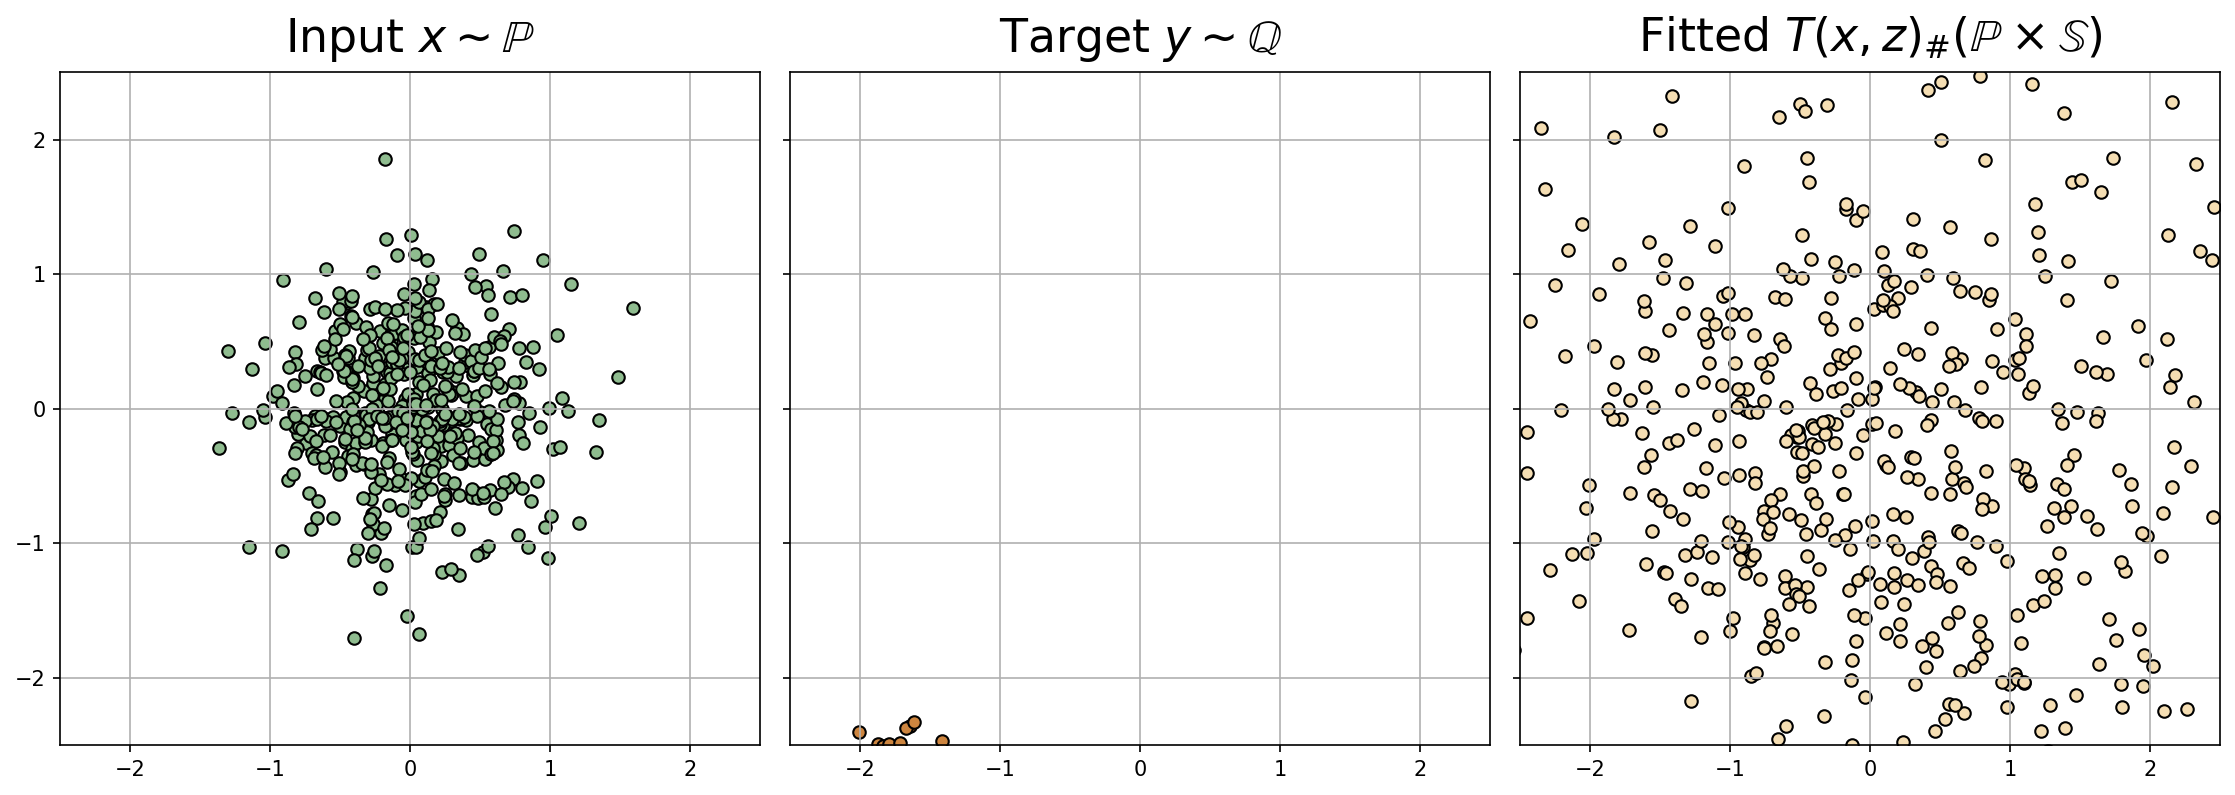

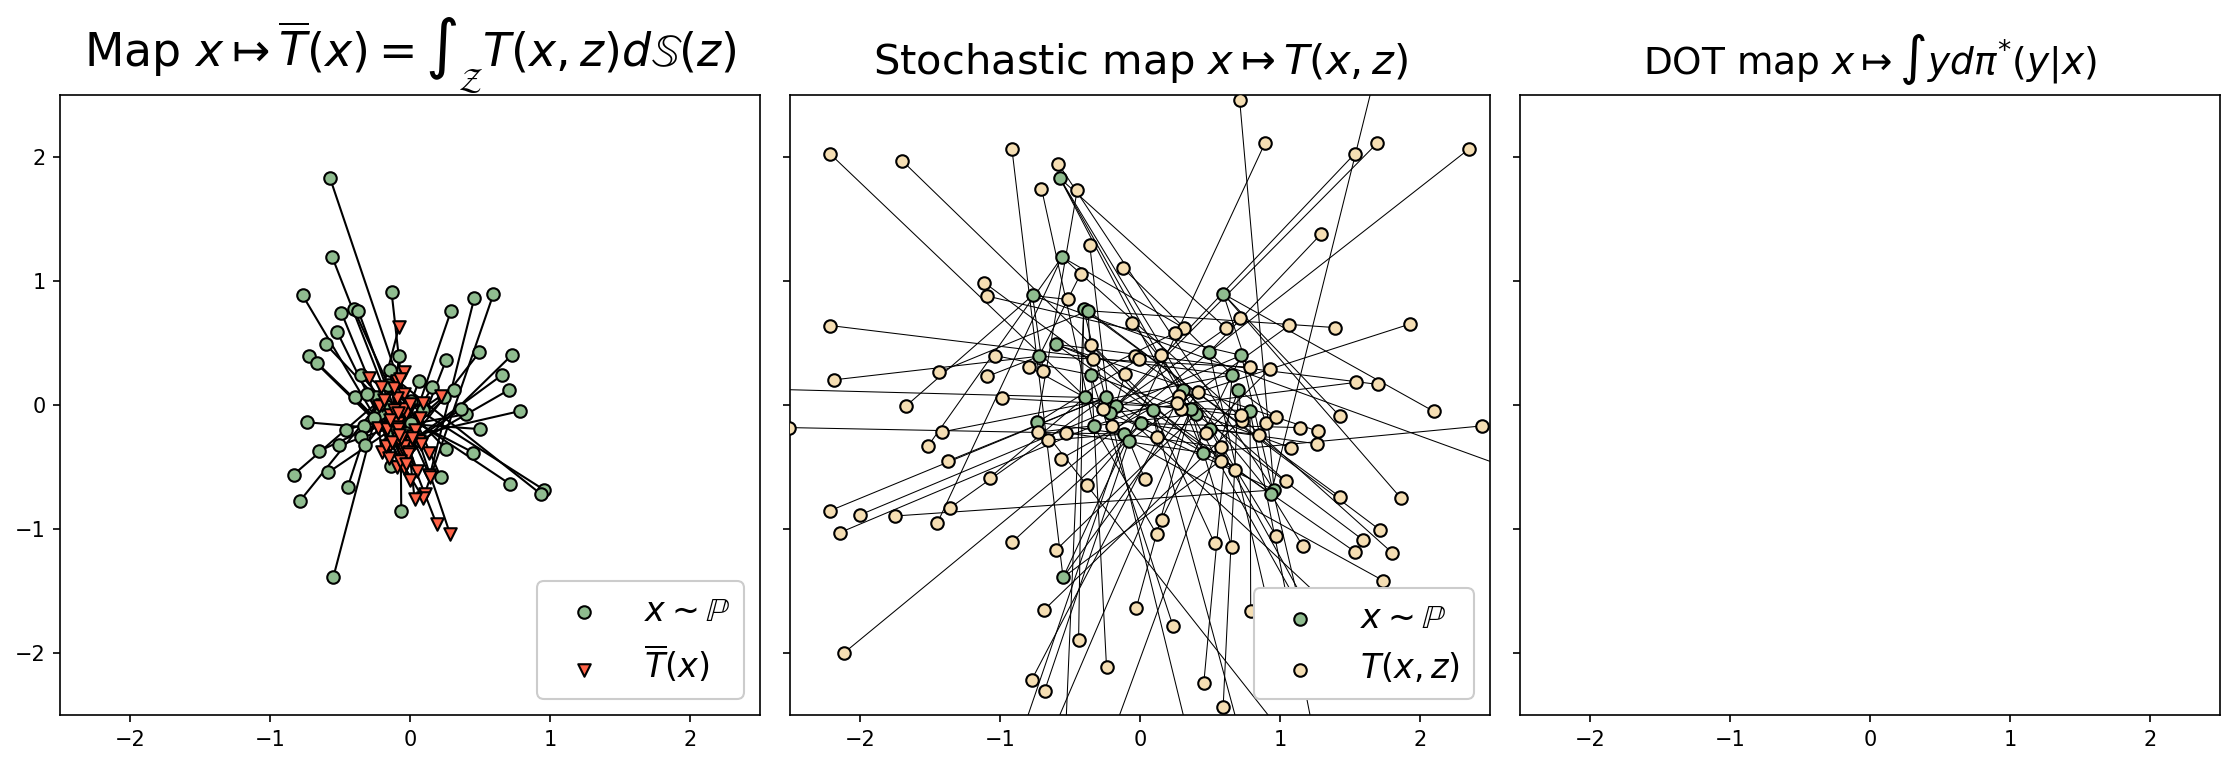

KeyboardInterrupt: 

In [19]:
from EntropicOTBenchmark.benchmark.metrics import calculate_cond_bw, compute_BW_UVP_by_gt_samples

for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T);
    freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE).cuda()
        T_XZ, log_prob = T.sample_and_log_prob(
            Z_SIZE,
            context=X
        )

        T_loss = 0.5 * F.mse_loss(X.unsqueeze(1), T_XZ, reduction='sum') / BATCH_SIZE / Z_SIZE - f(
            T_XZ).mean() + EPS * log_prob.mean()
        T_loss.backward();
        T_opt.step()

    del T_loss, T_XZ, X
    gc.collect();
    torch.cuda.empty_cache()

    # f optimization
    freeze(T);
    unfreeze(f)

    X = X_sampler.sample(BATCH_SIZE).cuda()
    with torch.no_grad():
        T_XZ = T.sample(Z_SIZE, context=X)
    Y = Y_sampler.sample(BATCH_SIZE).cuda()

    f_opt.zero_grad()
    f_loss = f(T_XZ).mean() - f(Y).mean()
    f_loss.backward();
    f_opt.step()

    del f_loss, Y, X, T_XZ
    gc.collect();
    torch.cuda.empty_cache()

    if step % PLOT_INTERVAL == 0:
        with torch.no_grad():
            clear_output(wait=True)
            print("Step", step)
            print("Plotting")
            print("(DOT map appears only on the last step)")

            fig, axes = plot_generated_2D(X_sampler, Y_sampler, compat_patch(T), ZD, Z_STD)
            plt.show()

            fig, axes = plot_bar_and_stochastic_2D(
                X_sampler, Y_sampler, compat_patch(T), ZD, Z_STD,
                plot_discrete=True if step == MAX_STEPS - 1 else False
            )
            plt.show()

    gc.collect()
    torch.cuda.empty_cache()

In [20]:
test_samples = get_test_input_samples(dim=DIM, device=DEVICE_IDS[0])

predictions = []
for i in tqdm(range(1000)):
    X_cond = test_samples[i][None, :]
    X_cond_predicted = T.sample(1000, context=X_cond)

    predictions.append(X_cond_predicted)

predictions = torch.stack(predictions, dim=0)

cond_bw = calculate_cond_bw(test_samples, predictions, eps=EPS, dim=DIM)

X = X_sampler.sample(100000).cuda()
Y = Y_sampler.sample(100000).cuda()

XN = T.sample(1, X).squeeze(1)
X0_XN = torch.cat((X, XN), dim=1)

X0_gt, XN_gt = ground_truth_plan_sampler.sample(100000)
X0_XN_gt = torch.cat((X0_gt, XN_gt), dim=1)

bw_uvp_target = compute_BW_UVP_by_gt_samples(XN.cpu().numpy(), Y.cpu().numpy())
bw_uvp_plan = compute_BW_UVP_by_gt_samples(X0_XN.cpu().numpy(), X0_XN_gt.cpu().numpy())

print(f"bw_uvp_target: {bw_uvp_target}, bw_uvp_plan: {bw_uvp_plan}, cond_bw: {cond_bw}")

  0%|          | 0/1000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.93 GiB total capacity; 2.45 GiB already allocated; 7.50 MiB free; 2.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF